This notebook shows an end-to-end usage of pycaffe2: we train the MNIST network purely from Python, and show the various intermediate results that we can dump from the network.

We will be using stochastic gradient descent, and everything would be implemented as Caffe2 networks: as you can see, we no longer have the conventional definition of a "network" and a "solver". Everything is basically a set of operators run at a given order: the training runs the forward pass, then the backward pass, then the update pass.

In [1]:
# First, let's import a few stuff.
%matplotlib inline
from matplotlib import pyplot
import numpy as np
from pycaffe2 import core, core_gradients, workspace, visualize

loaded nvd3 IPython extension
run nvd3.IPython_wrapper.initialize_javascript() to set up the notebook
help(nvd3.IPython_wrapper.initialize_javascript) for options


In [2]:
# Let's define the network.
# These are the initialization of all the parameters.
init_net = core.Net("init")
filter1 = init_net.XavierFill([], "filter1", shape=[20, 5, 5, 1])
bias1 = init_net.ConstantFill([], "bias1", shape=[20,], value=0.0)
filter2 = init_net.XavierFill([], "filter2", shape=[50, 5, 5, 20])
bias2 = init_net.ConstantFill([], "bias2", shape=[50,], value=0.0)
W3 = init_net.XavierFill([], "W3", shape=[500, 800])
B3 = init_net.ConstantFill([], "B3", shape=[500], value=0.0)
W4 = init_net.XavierFill([], "W4", shape=[10, 500])
B4 = init_net.ConstantFill([], "B4", shape=[10], value=0.0)

# These three parameters are just used to build up the SGD procedure.
LR = init_net.ConstantFill([], "LR", shape=[1], value=-0.1)
ONE = init_net.ConstantFill([], "ONE", shape=[1], value=1.0)
DECAY = init_net.ConstantFill([], "DECAY", shape=[1], value=0.999)

# This is the training network
train_net = core.Net("train")
data, label = train_net.TensorProtosDBInput(
    [], ["data", "label"], batch_size=64,
    db="../gen/data/mnist/mnist-train-minidb", db_type="minidb")
conv1 = data.Conv([filter1, bias1], "conv1", kernel=5, pad=0, stride=1, order="NHWC")
pool1, maxid1 = conv1.MaxPool([], ["pool1", "maxid1"], kernel=2, stride=2, order="NHWC")
conv2 = pool1.Conv([filter2, bias2], "conv2", kernel=5, pad=0, stride=1, order="NHWC")
pool2, maxid2 = conv2.MaxPool([], ["pool2", "maxid2"], kernel=2, stride=2, order="NHWC")
flatten2 = pool2.Flatten([], "pool2_flatten")
softmax = (flatten2.FC([W3, B3], "fc3")
                   .Relu([], "fc3_relu")
                   .FC([W4, B4], "pred")
                   .Softmax([], "softmax"))
# Cross entropy, and accuracy
xent = softmax.LabelCrossEntropy([label], "xent")
# The loss function in this case is simply an average over all data points.
loss, xent_grad = xent.AveragedLoss([], ["loss", xent.Grad()])

# Get gradient, skipping the input and flatten layers.
train_net.AddGradientOperators()
accuracy = softmax.Accuracy([label], "accuracy")

# Parameter updates
for param in [filter1, bias1, filter2, bias2, W3, B3, W4, B4]:
  train_net.WeightedSum([param, ONE, param.Grad(), LR], param)
for param in [filter1, bias1, filter2, bias2, W3, B3, W4, B4]:
  train_net.Summarize(param, [], to_file=1)
LR = train_net.Mul([LR, DECAY], "LR")

In [3]:
print str(train_net.Proto())

name: "train"
op {
  output: "data"
  output: "label"
  name: ""
  type: "TensorProtosDBInput"
  arg {
    name: "db_type"
    s: "minidb"
  }
  arg {
    name: "db"
    s: "../gen/data/mnist/mnist-train-minidb"
  }
  arg {
    name: "batch_size"
    i: 64
  }
}
op {
  input: "data"
  input: "filter1"
  input: "bias1"
  output: "conv1"
  name: ""
  type: "Conv"
  arg {
    name: "kernel"
    i: 5
  }
  arg {
    name: "pad"
    i: 0
  }
  arg {
    name: "order"
    s: "NHWC"
  }
  arg {
    name: "stride"
    i: 1
  }
}
op {
  input: "conv1"
  output: "pool1"
  output: "maxid1"
  name: ""
  type: "MaxPool"
  arg {
    name: "kernel"
    i: 2
  }
  arg {
    name: "order"
    s: "NHWC"
  }
  arg {
    name: "stride"
    i: 2
  }
}
op {
  input: "pool1"
  input: "filter2"
  input: "bias2"
  output: "conv2"
  name: ""
  type: "Conv"
  arg {
    name: "kernel"
    i: 5
  }
  arg {
    name: "pad"
    i: 0
  }
  arg {
    name: "order"
    s: "NHWC"
  }
  arg {
    name: "stride"
    i: 1


In [4]:
# Now, let's create the networks.
workspace.CreateNet(init_net.Proto().SerializeToString())
workspace.CreateNet(train_net.Proto().SerializeToString())

True

In [5]:
# Let's now run the network once, and inspect what we got.
workspace.RunNet("init")
workspace.RunNet("train")
# Let's show what blobs there are in the workspace for now.
print workspace.Blobs()

['B3', 'B3_grad', 'B4', 'B4_grad', 'DECAY', 'LR', 'ONE', 'W3', 'W3_grad', 'W4', 'W4_grad', 'accuracy', 'bias1', 'bias1_grad', 'bias2', 'bias2_grad', 'conv1', 'conv1_grad', 'conv2', 'conv2_grad', 'data', 'data_grad', 'fc3', 'fc3_grad', 'fc3_relu', 'fc3_relu_grad', 'filter1', 'filter1_grad', 'filter2', 'filter2_grad', 'label', 'loss', 'maxid1', 'maxid2', 'pool1', 'pool1_grad', 'pool2', 'pool2_flatten', 'pool2_flatten_grad', 'pool2_grad', 'pred', 'pred_grad', 'softmax', 'softmax_grad', 'xent', 'xent_grad']


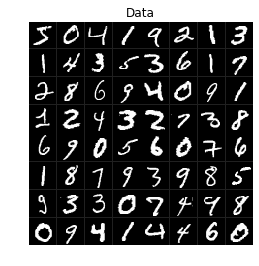

In [6]:
# Now, let's show some of the contents.
_ = visualize.ShowMultiple(workspace.FetchBlob('data'))
pyplot.title('Data')

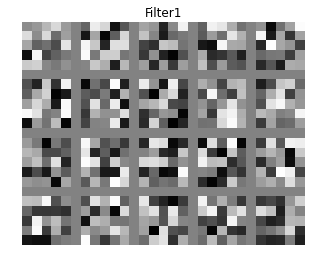

In [7]:
_ = visualize.ShowMultiple(workspace.FetchBlob('filter1'))
pyplot.title('Filter1')

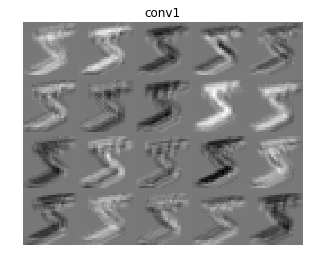

In [8]:
_ = visualize.ShowChannels(workspace.FetchBlob('conv1')[0])
pyplot.title('conv1')

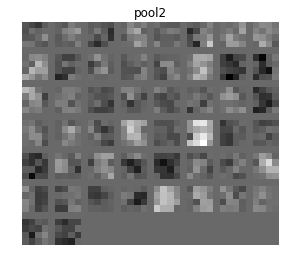

In [9]:
_ = visualize.ShowChannels(workspace.FetchBlob('pool2')[0])
pyplot.title('pool2')

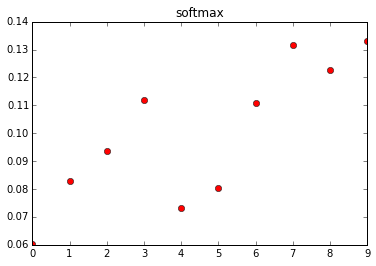

In [10]:
_ = pyplot.plot(workspace.FetchBlob('softmax')[0].flatten(), "ro")
pyplot.title('softmax')

Now, since the train network actually does training, we can basically call it multiple times, and the benefit of Python is that we can look at the loss and the accuracy at every iteration, and plot them.

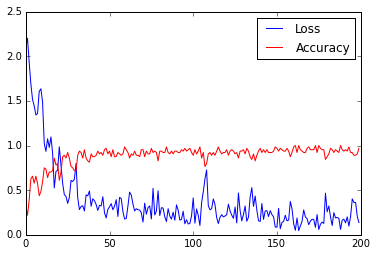

In [11]:
accuracy = np.zeros(200)
loss = np.zeros(200)
workspace.RunNet("init")
for i in range(200):
    workspace.RunNet("train")
    accuracy[i] = workspace.FetchBlob('accuracy')[0]
    loss[i] = workspace.FetchBlob('loss')
pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

Of course, you don't have to run networks one step by one step. This is only for fine-grained controls. For a detail-agnostic way to train stuff (which is also the C++ way), you can just define a plan that says "I want to train the network for 2000 iterations"), and run that plan directly. Let's do this.

In [12]:
# OK, so let's run the training procedure by putting it in a plan.
plan = core.Plan("mnist_lenet")
plan.AddNets([init_net, train_net])
plan.AddStep(core.ExecutionStep("init", init_net))
plan.AddStep(core.ExecutionStep("train", train_net, 200))
print 'Running plan...'
workspace.RunPlan(plan.Proto().SerializeToString())
print 'Plan finished.'

Running plan...
Plan finished.


After this, let's re-show some of the blobs. They will look pretty good!

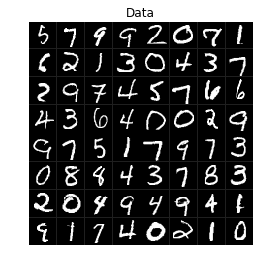

In [13]:
# Now, let's re-show some of the activations
_ = visualize.ShowMultiple(workspace.FetchBlob('data'))
pyplot.title('Data')

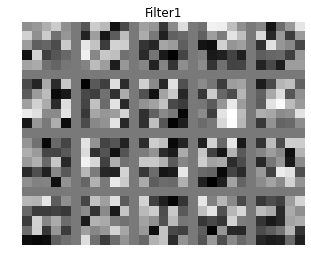

In [14]:
_ = visualize.ShowMultiple(workspace.FetchBlob('filter1'))
pyplot.title('Filter1')

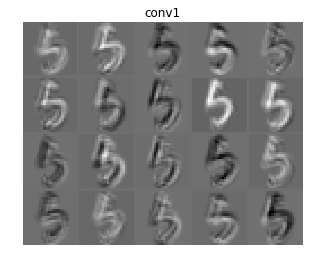

In [15]:
_ = visualize.ShowChannels(workspace.FetchBlob('conv1')[0])
pyplot.title('conv1')

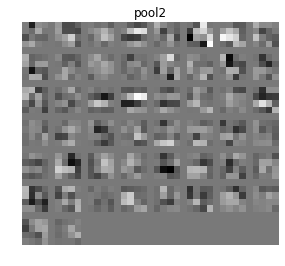

In [16]:
_ = visualize.ShowChannels(workspace.FetchBlob('pool2')[0])
pyplot.title('pool2')

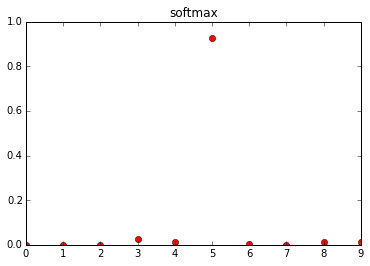

In [17]:
_ = pyplot.plot(workspace.FetchBlob('softmax')[0].flatten(), "ro")
pyplot.title('softmax')